In [1]:
import pandas as pd

df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
print(df.shape)
print(df.dtypes)
print(df.isnull().sum())

(7043, 21)
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod

In [3]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [4]:
df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

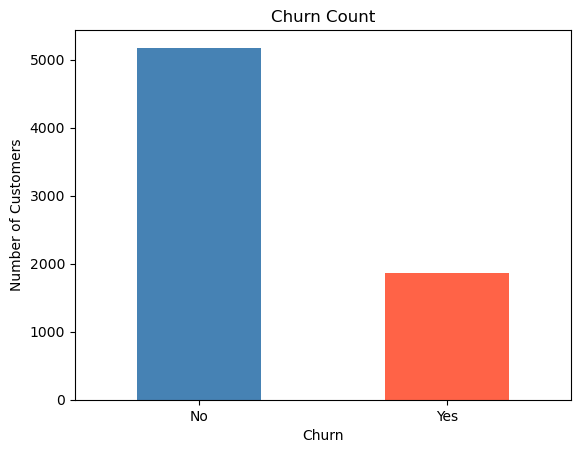

In [5]:
import matplotlib.pyplot as plt

df['Churn'].value_counts().plot(kind='bar', color=['steelblue', 'tomato'])
plt.title('Churn Count')
plt.xlabel('Churn')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.show()

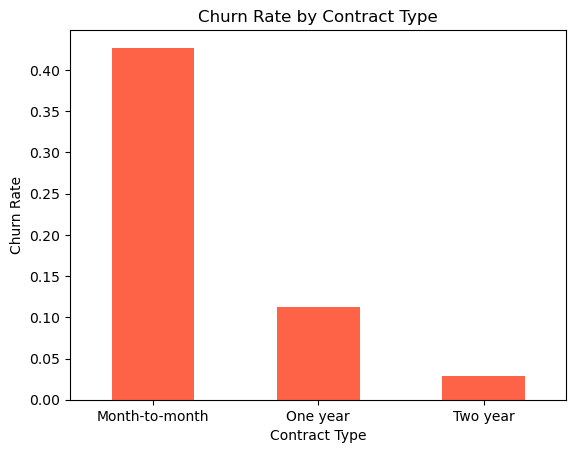

In [6]:
contract_churn = df.groupby('Contract')['Churn'].value_counts(normalize=True).unstack()
contract_churn['Yes'].plot(kind='bar', color='tomato')
plt.title('Churn Rate by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Churn Rate')
plt.xticks(rotation=0)
plt.show()

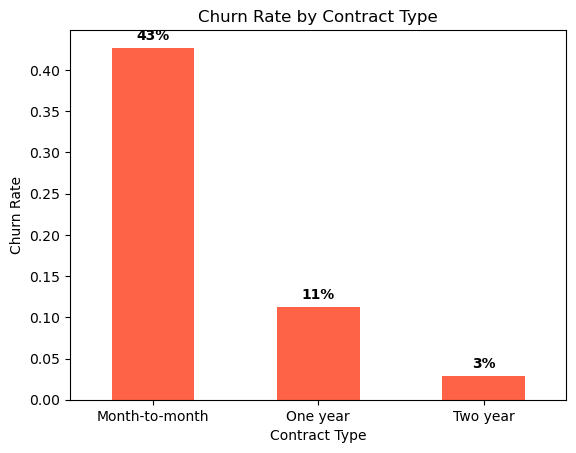

In [7]:
contract_churn = df.groupby('Contract')['Churn'].value_counts(normalize=True).unstack()
ax = contract_churn['Yes'].plot(kind='bar', color='tomato')
plt.title('Churn Rate by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Churn Rate')
plt.xticks(rotation=0)

for i, v in enumerate(contract_churn['Yes']):
    ax.text(i, v + 0.01, f'{v:.0%}', ha='center', fontweight='bold')

plt.show()

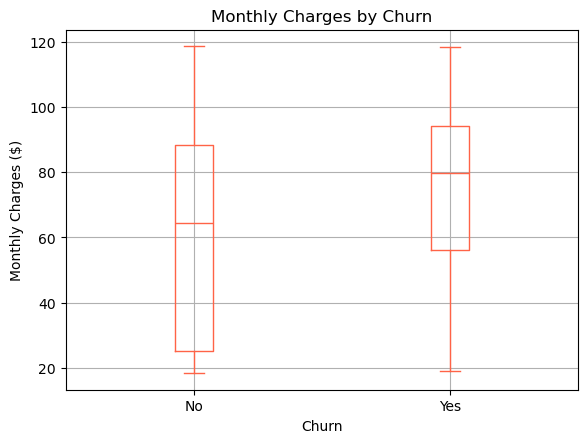

In [8]:
df.boxplot(column='MonthlyCharges', by='Churn', color='tomato')
plt.title('Monthly Charges by Churn')
plt.suptitle('')
plt.xlabel('Churn')
plt.ylabel('Monthly Charges ($)')
plt.show()

In [9]:
import sqlite3

conn = sqlite3.connect('churn.db')
df.to_sql('customers', conn, if_exists='replace', index=False)
print("Database created successfully!")

Database created successfully!


In [10]:
query = """
SELECT Churn, COUNT(*) as total_customers
FROM customers
GROUP BY Churn
"""

result = pd.read_sql(query, conn)
print(result)

  Churn  total_customers
0    No             5174
1   Yes             1869


In [11]:
query = """
SELECT Contract,
       COUNT(*) as total_customers,
       SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) as churned,
       ROUND(SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 1) as churn_rate_pct
FROM customers
GROUP BY Contract
ORDER BY churn_rate_pct DESC
"""

result = pd.read_sql(query, conn)
print(result)

         Contract  total_customers  churned  churn_rate_pct
0  Month-to-month             3875     1655            42.7
1        One year             1473      166            11.3
2        Two year             1695       48             2.8


In [12]:
query = """
SELECT Churn,
       ROUND(AVG(MonthlyCharges), 2) as avg_monthly_charges,
       ROUND(MIN(MonthlyCharges), 2) as min_charges,
       ROUND(MAX(MonthlyCharges), 2) as max_charges
FROM customers
GROUP BY Churn
"""

result = pd.read_sql(query, conn)
print(result)

  Churn  avg_monthly_charges  min_charges  max_charges
0    No                61.27        18.25       118.75
1   Yes                74.44        18.85       118.35


In [13]:
from sklearn.preprocessing import LabelEncoder

df2 = df.copy()

# Fix TotalCharges column (it has some empty values stored as spaces)
df2['TotalCharges'] = pd.to_numeric(df2['TotalCharges'], errors='coerce')
df2['TotalCharges'].fillna(df2['TotalCharges'].median(), inplace=True)

# Convert all text columns to numbers
le = LabelEncoder()
for col in df2.select_dtypes(include='object').columns:
    df2[col] = le.fit_transform(df2[col])

print("Data is ready!")
print(df2.shape)

Data is ready!
(7043, 21)


C:\Users\Andre\AppData\Local\Temp\ipykernel_13588\2544100394.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['TotalCharges'].fillna(df2['TotalCharges'].median(), inplace=True)


In [14]:
from sklearn.preprocessing import LabelEncoder

df2 = df.copy()

# Fix TotalCharges column (it has some empty values stored as spaces)
df2['TotalCharges'] = pd.to_numeric(df2['TotalCharges'], errors='coerce')
df2['TotalCharges'] = df2['TotalCharges'].fillna(df2['TotalCharges'].median())

# Convert all text columns to numbers
le = LabelEncoder()
for col in df2.select_dtypes(include='object').columns:
    df2[col] = le.fit_transform(df2[col])

print("Data is ready!")
print(df2.shape)

Data is ready!
(7043, 21)


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Separate the data into features (X) and what we're predicting (y)
X = df2.drop(columns=['Churn', 'customerID'])
y = df2['Churn']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model
model = LogisticRegression(max_iter=3000)
model.fit(X_train, y_train)

# Test the model
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.0%}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 82%

Confusion Matrix:
[[934 102]
 [156 217]]


In [17]:
# Add a readable churn prediction column
df['Predicted_Churn'] = model.predict(X)

# Convert prediction from number back to Yes/No
df['Predicted_Churn'] = df['Predicted_Churn'].map({1: 'Yes', 0: 'No'})

# Export to CSV
df.to_csv('churn_dashboard.csv', index=False)
print("File exported successfully!")

File exported successfully!
